## Example notebook to post-process the chains and add contributions from the likelihood from each cell

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)
import time
from pathlib import Path
from functools import partial

import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=12)
from getdist import plots

%matplotlib inline

save_dir = Path("/pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1")
save_path = save_dir / "test"

## Looking at chains

In [2]:
# Load chain files, which are just dictionaries of arrays, saved with jnp.savez
model = FieldLevelModel.load(save_dir / "model.yaml")

truth = dict(jnp.load(save_dir / 'truth.npz'))

varied_params = ['b1_', 'b2_', 'bn2_', 'bs2_', 'ngbars_', 'sigma_0_', 'sigma_delta_', 'init_mesh_']

chains = model.load_runs(save_path, 1, 8, transforms=[])

Loading: test, from run 1 to run 8 (included)


In [3]:
chains[varied_params[:-1]].print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           b1_      1.30      0.51      1.33      0.43      2.11   1303.42      1.00
           b2_      0.28      0.71      0.27     -0.87      1.45    302.29      1.01
          bn2_      6.34      4.33      6.31     -0.70     13.45   5383.87      1.00
          bs2_      4.29      2.73      4.26     -0.16      8.72   3324.69      1.00
    ngbars_[0]     -0.35      0.50     -0.36     -1.18      0.45   5034.26      1.00
      sigma_0_      6.68      3.24      6.47      1.25     11.69   1003.37      1.00
  sigma_delta_     -3.94      3.43     -4.09     -9.63      1.61    170.47      1.02



Removed no burn in


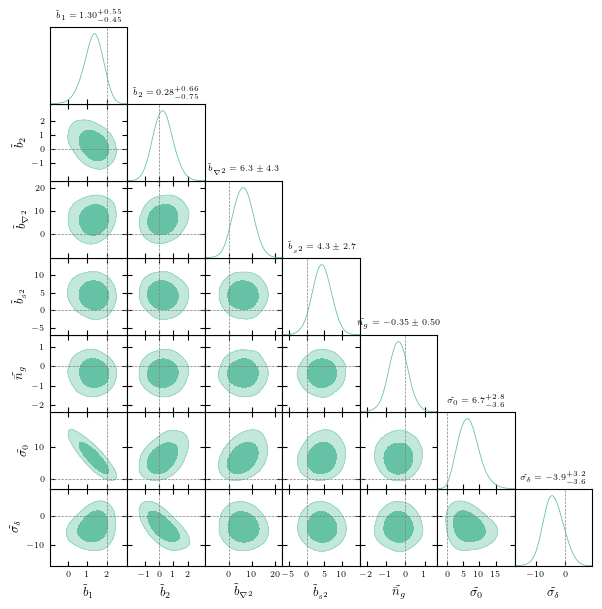

In [4]:
gdsamp = chains[varied_params[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True,
                markers=truth,
                contour_colors=[SetDark2(0)]);

## Rewrite the log-likelihood explicitely to isolate the contribution from each cell

In [5]:
# Mirroring what's in https://github.com/hsimonfroy/montecosmo/blob/main/montecosmo/model.py

from montecosmo.model import mesh2masked
from numpyro import sample, deterministic, render_model, handlers, distributions as dist
from numpyro.infer.util import log_density

import jax.numpy as jnp
from jax.scipy.special import gammaln

def poisson_logpmf(k, var):
    """
    Log-probability of Poisson(k | λ = var), vectorized and JAX-friendly.
    """
    lam = var
    return k * jnp.log(lam) - lam - gammaln(k + 1)

def gaussian_logpdf(x, mean, std):
    """
    Log-PDF of a Gaussian N(mean, std^2).
    Vectorized, stable, JIT- and grad-friendly.
    """
    var = std * std
    return -0.5 * (
        jnp.log(2 * jnp.pi)
        + 2 * jnp.log(std)
        + (x - mean) ** 2 / var
    )

def get_loglkl_in_cell(self, pred, truth, temp=1.):
    # I'd like it to return the logpdf for each cell of the mesh at once
    # Then I can super easily compute the contribution of a given cell
    # self is model
    mesh = pred['gxy_mesh']
    obs = truth['obs']
    syst = pred
    if self.observable == 'field':
        # print("mesh", mesh.mean(), mesh.std(), mesh.min(), mesh.max())
        mesh = mesh2masked(mesh * self.selec_mesh, self.mask)
        # print("mesh", mesh.mean(), mesh.std(), mesh.min(), mesh.max())
        # mesh /= mesh.mean()

        rcounts = pred['ngbars'] * self.cell_length**3
        mean_count = rcounts.mean()            
        # nmesh = set_radial_count(mesh, self.rmasked, self.redges, rcounts)

        # posit_fn = lambda x: jnp.maximum(x, 1e-9)
        # posit_fn = jnp.abs
        posit_fn = lambda x: jnp.log(1 + jnp.exp(x))

        if self.lik_type == 'poisson':
            # intens = posit_fn(mesh * mean_count)
            intens = posit_fn(mesh) * mean_count
            var = intens**(1 / temp)
            return poisson_logpmf(obs, var)
        else:
            if self.lik_type == 'gaussian':
                var = syst['sigma_0']
            elif self.lik_type == 'gaussian_delta':
                delta = mesh - 1
                var = posit_fn(1 + syst['sigma_delta'] * delta) * syst['sigma_0']
                # var = posit_fn((1 + syst['sigma_delta'] * delta) * syst['sigma_0'])
            mean = mesh * mean_count
            std = (temp * var * self.cell_length**3)**.5
            return gaussian_logpdf(obs, mean, std)

In [6]:
def get_loglkl(varied):
    """Return log-likelihood per cell based on input varied parameters."""
    samples = truth | varied
    pred = model.predict(samples=samples, hide_det=False, hide_base=False, hide_samp=False, from_base=False)
    return get_loglkl_in_cell(model, pred, truth)


In [7]:
# Now post-processing the chains, one batch at a time
for i_run in range(1, 8):
    model.reset()
    chains = model.load_runs(save_path, i_run, i_run, transforms=[])
    # Condition model on fixed parameters
    samples = {name: chains.data[name].reshape(-1, *chains.data[name].shape[2:])  for name in varied_params}
    loglkl = jax.lax.map(get_loglkl, samples, batch_size=100)
    chains['delta_logdensity'] = -loglkl.reshape(*chains.data[varied_params[0]].shape[:2], *loglkl.shape[1:])
    fn = f"{save_path}_with_delta_logdensity_{i_run}.npz"
    print(f'Saving to {fn}')
    jnp.savez(fn, **chains.data)

Loading: test, from run 1 to run 1 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_delta_logdensity_1.npz
Loading: test, from run 2 to run 2 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_delta_logdensity_2.npz
Loading: test, from run 3 to run 3 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_delta_logdensity_3.npz
Loading: test, from run 4 to run 4 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_delta_logdensity_4.npz
Loading: test, from run 5 to run 5 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_delta_logdensity_5.npz
Loading: test, from run 6 to run 6 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_delta_logdensity_6.npz
Loading: test, from run 7 to run 7 (included)
Saving to /pscratch/sd/h/hsimfroy/png/leave1out/lpt_32_eh1_ovsamp1/test_with_d